In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

import seaborn as sns

from tqdm.auto import tqdm

import os
import ctypes

In [2]:
dirname = '../src/model_ctypes/_koivumaki/'
filename_so = os.path.join(dirname, 'koivumaki.so')

filename_so_abs = os.path.abspath(filename_so)

model = ctypes.CDLL(filename_so_abs)

model.initialize_states_default.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]

model.initialize_states_default.restype = ctypes.c_void_p


model.run.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS')
]

model.run.restype = ctypes.c_int

legend_constants = pd.read_csv(os.path.join(dirname, "legend_constants.csv"), index_col='name')['value']
legend_states = pd.read_csv(os.path.join(dirname, "legend_states.csv"), index_col='name')['value']

model.initialize_states_default(legend_states.values, legend_constants.values)

4621082499826719547

In [3]:
S = legend_states.copy()
C = legend_constants.copy()

In [4]:
t_sampling = 0.001

stim_period = C['STIM_PERIOD']
n_samples_per_stim = int(stim_period / t_sampling)

n_beats = 1500
tol = 1e-3

output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))

In [7]:
status = model.run(S.values.copy(), C.values.copy(),
                   n_beats, t_sampling, tol, output)

print(status)

2


In [8]:
output = pd.DataFrame(output, columns=legend_states.index)

In [9]:
volumes = legend_constants[['Vss'] + [f'Vnonjunct{i}' for i in range(1, 4 + 1)]]

concentrations = output[['Cass'] + [f'Cai{i}' for i in range(1, 4 + 1)]]
Cai_mean = (concentrations.values * volumes.values).sum(axis=1) / sum(volumes)

concentrations = output[['fluo_ss'] + [f'fluo_{i}' for i in range(1, 4 + 1)]]
fluo_mean = (concentrations.values * volumes.values).sum(axis=1) / sum(volumes)

output['Cai_mean'] = Cai_mean
output['fluo_mean'] = fluo_mean

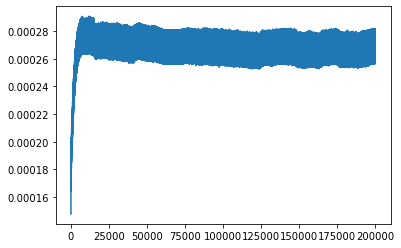

In [10]:
plt.plot(output.Cai_mean)

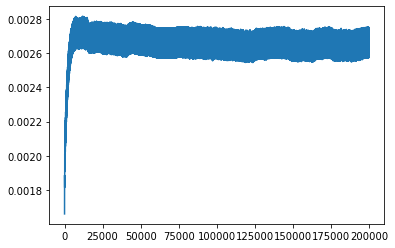

In [11]:
plt.plot(output.fluo_mean)

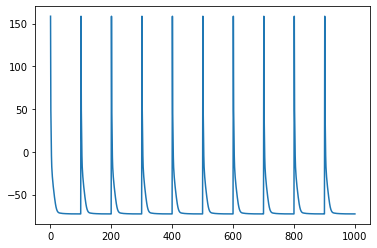

In [15]:
plt.plot(output.V[-1000:])

In [6]:
from matplotlib import cm

0it [00:00, ?it/s]

<ipython-input-7-ea5c2743275e>:26: RuntimeWarning: divide by zero encountered in true_divide
  output['fluo_rel'] = fluo_mean / fluo_tot * 100


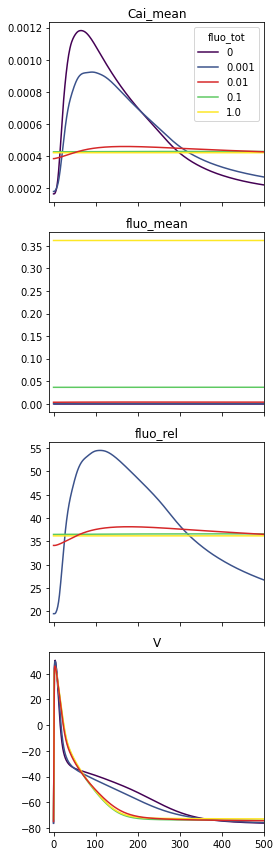

In [7]:
columns = 'Cai_mean', 'fluo_mean', 'fluo_rel', 'V'

fig, axes = plt.subplots(nrows=len(columns), figsize=plt.figaspect(3), sharex=True)

for i, fluo_tot in tqdm(enumerate([0, 0.001, 0.01, 0.1, 1.])):
    
    C['fluo_tot'] = fluo_tot
    model.initialize_states_default(S.values, C.values)

    output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
    status = model.run(S.values.copy(), C.values.copy(),
                       n_beats, t_sampling, tol, output)
    output = output[-1001:]
    output = pd.DataFrame(output, columns=legend_states.index)
    
    volumes = legend_constants[['Vss'] + [f'Vnonjunct{i}' for i in range(1, 4 + 1)]]

    concentrations = output[['Cass'] + [f'Cai{i}' for i in range(1, 4 + 1)]]
    Cai_mean = (concentrations.values * volumes.values).sum(axis=1) / sum(volumes)

    concentrations = output[['fluo_ss'] + [f'fluo_{i}' for i in range(1, 4 + 1)]]
    fluo_mean = (concentrations.values * volumes.values).sum(axis=1) / sum(volumes)

    output['Cai_mean'] = Cai_mean
    output['fluo_mean'] = fluo_mean
    output['fluo_rel'] = fluo_mean / fluo_tot * 100
    
    for ic, c in enumerate(columns):
        x = output[c][-1000-1:].values
        color = 'C3' if fluo_tot == 0.01 else cm.viridis(i / 4)
        zorder = fluo_tot == 0.01
        axes[ic].plot(x, label=str(fluo_tot), color=color, zorder=zorder)
    
for ic, c in enumerate(columns):
    plt.sca(axes[ic])
    plt.xlim(-10, 500)
    plt.title(c)

plt.tight_layout()
axes[0].legend(title='fluo_tot')

plt.savefig("../images/fluo/koivumaki.png", dpi=600)